# using Pkg
Pkg.add(["PyPlot","UMAP","LinearAlgebra","Distributions","Random","Flux","Zygote","SpecialFunctions","StatsBase","BoltzmannMachines","Statistics","DelimitedFiles"])
Pkg.add(url="https://github.com/ssehztirom/LogLinearModels.jl")

In [1]:
using PyPlot
using UMAP
using LinearAlgebra
using Distributions
using Random
using Flux
using Zygote
using SpecialFunctions
using LogLinearModels
using StatsBase
using BoltzmannMachines
using Statistics
using DelimitedFiles

In [2]:
include("patternextractor.jl")

makeconstraint (generic function with 2 methods)

# Code for training VAEs

In [3]:
# Principal component analysis (PCA)

function standardize2(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = standardize2(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end


struct VAE
	encoder
	mu
	logsigma
	decoder
end

# struct XYZ
#    encoder

function bernoulliloss(xhat,x)
	ce(x,y) =  y * log(x + eps()) + (1 - y) * log(1 - x + eps())
	# logpdf(b::Bernoulli,y::Bool) = y * log(b.p + eps()) + (1-y) * log(1-b.p + eps())
	# return sum(Distributions.logpdf.(Bernoulli.(xhat),x))
	return sum(ce.(xhat,x))
end

    
function normalz(mu,logsigma)
	return mu  + exp(logsigma) * randn()
end



function kullbackleiblerqp(mu,logsigma)
	return 0.5 * sum(exp.(2 .* logsigma) + mu.^2 .- 1 .- 2 .* logsigma)
end


g(x) = (h = vae.encoder(x); (vae.mu(h), vae.logsigma(h)))	

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [4]:
function posteriorsample(x) 
    mu,logsigma = g(x)
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

function priorsample(x) 
    mu,logsigma = g(x)
    mu = zeros(length(mu))
    logsigma = zeros(length(logsigma))
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

priorsample (generic function with 1 method)

# Code for simulated data

In [5]:
n = 250
a = 2
b = -2

-2

In [6]:
g1c1z1 = rand(Normal(a,1),n)
g1c2z1 = rand(Normal(b,1),n)
g1c1z2 = rand(Normal(a,1),n)
g1c2z2 = rand(Normal(a,1),n)

g2c1z2 = rand(Normal(a,1),n)
g2c2z2 = rand(Normal(b,1),n)
g2c1z1 = rand(Normal(a,1),n)
g2c2z1 = rand(Normal(a,1),n)


250-element Vector{Float64}:
  0.7328341134464837
  1.1003733068497024
  2.52606949091402
  2.6806089305753513
  1.8367090102374695
  0.47230031043898535
 -0.7887268517534007
  3.8026492831190897
  1.8391482336297325
  2.9958798830561935
  2.724274580760915
  4.046069204037918
  3.6229008545128973
  ⋮
  2.9635135432903614
  2.7428520759757427
  3.6607623932048723
  2.31091680093392
  1.216086524843105
  3.943072087068514
  1.848033291172613
  4.911437470538475
  1.5788088425746452
  2.0918789391070263
  2.225987337986764
  2.5698179638207086

In [7]:
z1 = cat([g1c1z1,g1c2z1,g2c1z1,g2c2z1]...,dims=1)
z2 = cat([g1c1z2,g1c2z2,g2c1z2,g2c2z2]...,dims=1)

1000-element Vector{Float64}:
  2.2608923018402773
  3.241190087012056
  1.6670652923867704
  1.9666651033762719
  1.2825860424108946
  1.890665771858779
  0.5944312492256236
  1.0656146205650416
  1.8108320633089094
  1.2231928630746152
  1.3994050126028577
  2.4067458258938927
  1.5007399258863265
  ⋮
 -1.2787814757595872
 -0.6487950146118744
 -2.9077822373054296
 -3.060872585531432
 -2.0428449663247545
 -2.2621815633293654
 -2.3438806653383892
 -3.721140860776032
 -1.107210208498643
 -1.5673129402775021
 -3.7675472682328848
 -2.837888463257772

In [8]:
cellfactor = cat([fill(1,n),fill(2,n),fill(1,n),fill(3,n)]...,dims=1)
groupfactor = cat([fill(1,n*2),fill(2,n*2)]...,dims=1)

1000-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [9]:
col = ["r","deepskyblue"]
gcols = col[groupfactor]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor]

1000-element Vector{String}:
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 ⋮
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"

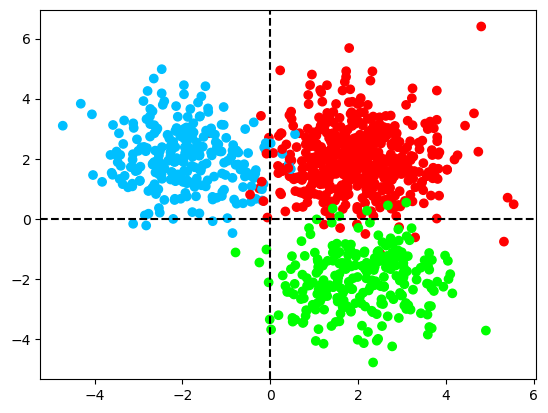

PyObject <matplotlib.lines.Line2D object at 0x20c227bb0>

In [10]:
PyPlot.scatter(z1,z2,c=ccols)
PyPlot.axhline(y = 0.0,c="black",linestyle="--")
PyPlot.axvline(x = 0.0,c="black",linestyle="--")

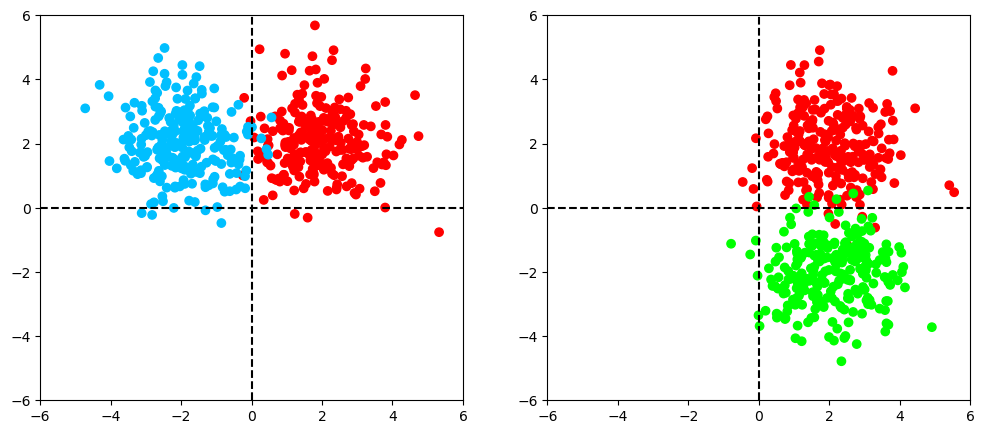

PyObject <matplotlib.lines.Line2D object at 0x20c470f70>

In [11]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
g1i = groupfactor .== 1
ax[1].scatter(z1[g1i],z2[g1i],c=ccols[g1i])
ax[1][:set_ylim]([-6,6])
ax[1][:set_xlim]([-6,6])
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
g2i = groupfactor .== 2
ax[2].scatter(z1[g2i],z2[g2i],c=ccols[g2i])
ax[2][:set_ylim]([-6,6])
ax[2][:set_xlim]([-6,6])
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [12]:
x = zeros(n*4,10)

1000×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.

In [13]:
for i=1:5
    x[:,i] = z1 + rand(Normal(0,1),n*4)
end

In [14]:
for i=6:10
    x[:,i] = z2 + rand(Normal(0,1),n*4)
end

In [15]:
x01 = convert(Array{Float64,2},ifelse.(x.>0,1,0))

1000×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮                   
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.

In [16]:
noisevars = convert(Array{Float64,2},rand(1000,20) .> 0.5)

1000×20 Matrix{Float64}:
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  1.0  0.0  1.0  1.0
 0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0     1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0     1.0  0.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0     0.0  0.0  1.0  1.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  …  1.0  1.0  1.0  0.0  0.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0     0.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0

In [17]:
x01 = hcat([x01,noisevars]...)

1000×30 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     1.0  0.0  1.0  0.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  1.0  1.0  0.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  …  1.0  1.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0     0.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

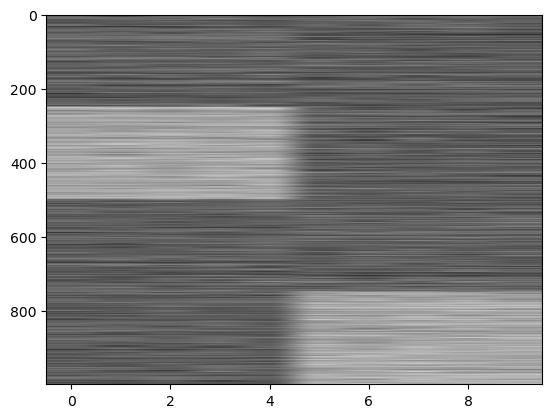

PyObject <matplotlib.image.AxesImage object at 0x20c500070>

In [18]:
PyPlot.imshow(x,aspect="auto",cmap="binary")

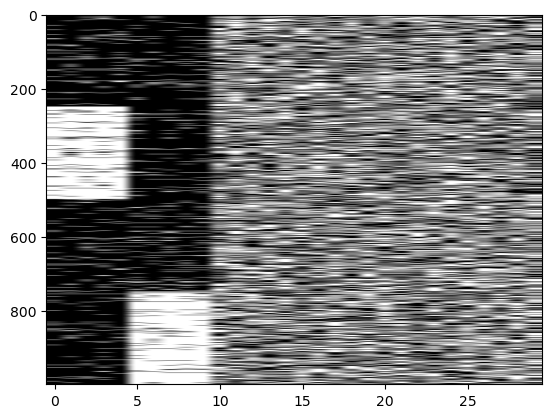

PyObject <matplotlib.image.AxesImage object at 0x20c548eb0>

In [19]:
PyPlot.imshow(x01,aspect="auto",cmap="binary")

## Simulated Data Ready, prepare for training VAE

In [20]:
n,p = size(x01)

(1000, 30)

In [21]:
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

In [22]:
testdata

368-element Vector{Adjoint{Float64, Matrix{Float64}}}:
 [0.0; 0.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [0.0; 0.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 0.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 ⋮
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [0.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]

In [23]:
col = ["lightgrey","k"]
gcols = col[groupfactor[testidx]]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor[testidx]]

368-element Vector{String}:
 "deepskyblue"
 "r"
 "r"
 "lime"
 "r"
 "r"
 "r"
 "deepskyblue"
 "r"
 "deepskyblue"
 "r"
 "r"
 "r"
 ⋮
 "lime"
 "lime"
 "r"
 "lime"
 "r"
 "r"
 "r"
 "lime"
 "r"
 "lime"
 "r"
 "r"

# Train VAE

In [24]:
Random.seed!(1234)
Dh = 30
Dz = 2
epochs = 50
learningrate = 0.004
batchsize=10
Beta =1

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end




In [25]:
Random.seed!(1234)
Dh = 30
Dz = 2
epochs = 50
learningrate = 0.004
batchsize=10
Beta =1

1

In [26]:
loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [27]:
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

VAE(Chain(Dense(30, 30, tanh)), Dense(30, 2), Dense(30, 2), Chain(Dense(2, 30, relu), Dense(30, 30, σ)))

In [28]:
optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)

Params([Float32[-0.21166883 -0.036679838 … -0.09168885 0.094487116; 0.050509237 0.23434964 … 0.27464327 -0.031743303; … ; -0.02800931 -0.13444553 … 0.2145687 0.22609095; 0.1939767 0.22877489 … -0.16312665 0.2823618], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.23465197 0.22051999 … 0.07838469 -0.034903724; 0.21626312 0.045496177 … -0.36964485 0.0015206997], Float32[0.0, 0.0], Float32[-0.42893928 0.370592 … 0.11676181 -0.32878834; 0.25255343 -0.03477674 … 0.225178 0.16739601], Float32[0.0, 0.0], Float32[0.1933963 0.06880604; 0.36454853 0.33934513; … ; 0.34757817 0.2702324; 0.3253124 0.11031515], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.14380309 -0.3017917 … 0.063717805 -0.0048677; 0.09285279 -0.01082798 … -0.13923407 0.11875712; … ; -0.31188414 0.052131128 … -0.29600835 0.16998582; 0.1445122 0.17016178 … -0.30094182 0.26255414], 

Write a custom training loop

In [29]:
losslist = []
for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end


# Check output from VAE

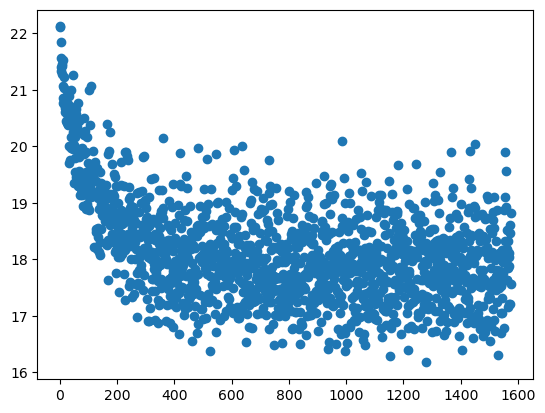

PyObject <matplotlib.collections.PathCollection object at 0x20c5b5dc0>

In [30]:
PyPlot.scatter(collect(1:length(losslist)),losslist)

## Plot expected value of latent variables

In [31]:
zs = Transpose(cat(dims=2,map(x-> x[1],g.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
  1.5058      0.123207
 -0.549647    1.19193
 -0.0415217   0.511469
 -1.17946    -1.16633
 -0.392466    1.22186
 -0.105383    1.0051
 -0.347966    1.21764
  1.61043    -0.200447
 -0.452464    1.22774
  1.51552     0.11358
 -0.467901    1.19624
 -0.513891    0.545332
 -0.371979    1.0966
  ⋮          
 -1.05145    -1.10758
 -1.2186     -1.25433
 -0.833437    0.0669104
 -1.04207    -1.17725
 -0.364383    1.11672
  0.239246    0.80546
 -0.435881    1.1083
 -0.956536   -1.43848
 -0.206713    0.962668
 -1.14021    -1.20452
 -0.959497   -0.15018
 -0.421986    1.24225

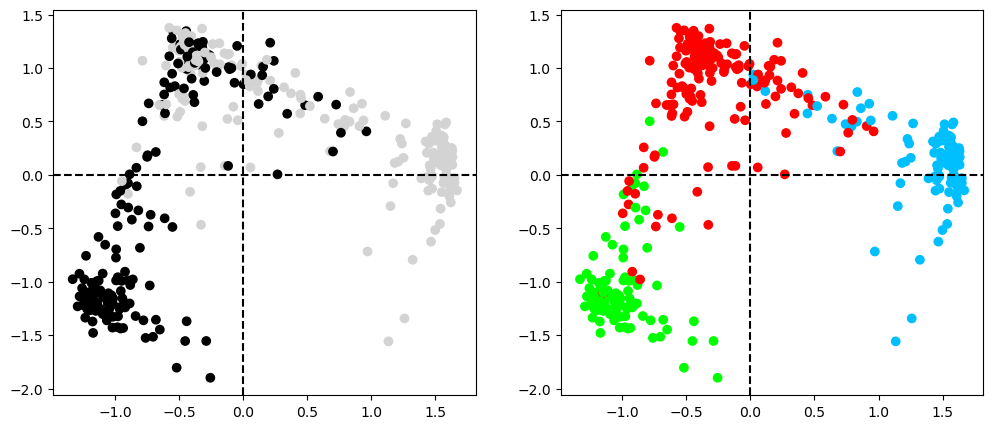

PyObject <matplotlib.lines.Line2D object at 0x214b87670>

In [32]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [33]:
zs = Transpose(cat(dims=2,map(x-> x[1],posteriorsample.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
  1.84032     0.841739
 -1.40834     1.00062
  0.677481   -0.0883592
 -0.323438   -1.32342
 -0.190128    0.468734
 -0.0442721   1.14164
  0.0699168   0.475345
  1.26776    -0.181895
 -0.191074    1.72034
  1.49769     0.618636
 -0.0954594   1.04226
 -0.529199    0.595601
 -1.35384     1.3424
  ⋮          
 -0.0803181  -0.363343
 -1.54529    -1.73235
 -0.400625    0.504407
 -1.0911     -1.6424
 -0.614164    0.618979
  0.602051    1.43174
 -0.800478    0.643278
 -1.08113    -1.8263
 -0.193153    0.357734
 -0.441258   -1.33309
 -1.47916    -0.483499
  0.0189339   0.961077

## Left labelled according to group, right labelled according to celltype

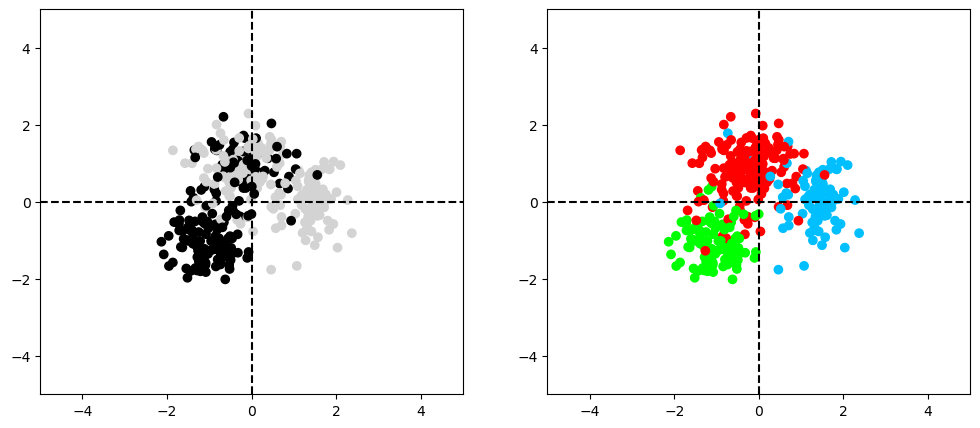

PyObject <matplotlib.lines.Line2D object at 0x214c5de20>

In [34]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 5
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

# Draw samples from trained VAE

In [35]:
vaesamples = priorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.8269663245760153, -0.6543917092606906], [0.19403867051777363, 0.2642424158633385, 0.18593861414251234, 0.2100772281921409, 0.21219306453663334, 0.801487625759605, 0.8354969121133552, 0.790210821468038, 0.8336626542184088, 0.8318566067787859  …  0.5154272430750375, 0.5391405206045854, 0.5038843696089585, 0.5029050809770714, 0.4734019925085631, 0.5049495914435516, 0.5138461009643914, 0.5163633837691749, 0.514225830570905, 0.5124567537903262])
 ([0.2961307245636859, -1.1629161916276305], [0.5523369299170825, 0.5925878110865471, 0.5440287620018139, 0.5550684938139986, 0.6449717521823128, 0.22853598336614253, 0.34168711990533135, 0.2758320367572918, 0.28550342083782, 0.3020858836805545  …  0.5305960608465035, 0.5222838996049823, 0.507896463515995, 0.5212375260809831, 0.5297379509545563, 0.5090111056926837, 0.5001275082428132, 0.49167632151361906, 0.5109221720821037, 0.4872817108843669])
 ([0.4724494433146802, -1.780194269978

In [36]:
vaepostsamples = posteriorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([1.8353711264822736; 0.7800352990971723;;], [0.04794982468410362; 0.06204802831855521; … ; 0.4529386257624529; 0.5402486428153755;;])
 ([0.5742368585076437; 1.3505459509499655;;], [0.8664991100530474; 0.8205686629071953; … ; 0.47304813615016883; 0.5429063578791363;;])
 ([-0.6191098167190703; -0.04783973415639031;;], [0.9777065339603949; 0.9666525511105166; … ; 0.4724151697202361; 0.4688703058394784;;])
 ([-1.6727070295972477; -0.8043934493246339;;], [0.9954336660121759; 0.9904525471696292; … ; 0.4156315611597643; 0.41081965524362435;;])
 ([-1.0857647516783573; 0.8494528248753488;;], [0.9960505845747224; 0.9923103021469775; … ; 0.4798939063533953; 0.4829819269313013;;])
 ([-0.23658243351980648; 1.6301521585778342;;], [0.9887496270063667; 0.9785363367502656; … ; 0.5024833383622647; 0.5480851432300285;;])
 ([-0.784239539206858; 1.3296414031259376;;], [0.9954722497492027; 0.9907679760981011; … ; 0.5030951502353611; 0.511733404

In [37]:
vaesamples = vaepostsamples

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([1.8353711264822736; 0.7800352990971723;;], [0.04794982468410362; 0.06204802831855521; … ; 0.4529386257624529; 0.5402486428153755;;])
 ([0.5742368585076437; 1.3505459509499655;;], [0.8664991100530474; 0.8205686629071953; … ; 0.47304813615016883; 0.5429063578791363;;])
 ([-0.6191098167190703; -0.04783973415639031;;], [0.9777065339603949; 0.9666525511105166; … ; 0.4724151697202361; 0.4688703058394784;;])
 ([-1.6727070295972477; -0.8043934493246339;;], [0.9954336660121759; 0.9904525471696292; … ; 0.4156315611597643; 0.41081965524362435;;])
 ([-1.0857647516783573; 0.8494528248753488;;], [0.9960505845747224; 0.9923103021469775; … ; 0.4798939063533953; 0.4829819269313013;;])
 ([-0.23658243351980648; 1.6301521585778342;;], [0.9887496270063667; 0.9785363367502656; … ; 0.5024833383622647; 0.5480851432300285;;])
 ([-0.784239539206858; 1.3296414031259376;;], [0.9954722497492027; 0.9907679760981011; … ; 0.5030951502353611; 0.511733404

In [38]:
zs = Transpose(cat(dims=2,map(x-> x[1],vaesamples)...))
xs = Transpose(cat(dims=2,map(x-> x[2],vaesamples)...))

3680×30 transpose(::Matrix{Float64}) with eltype Float64:
 0.0479498   0.062048   0.0419775   …  0.471189  0.452939  0.540249
 0.866499    0.820569   0.787402       0.437106  0.473048  0.542906
 0.977707    0.966653   0.955122       0.474146  0.472415  0.46887
 0.995434    0.990453   0.989858       0.444571  0.415632  0.41082
 0.996051    0.99231    0.986484       0.418339  0.479894  0.482982
 0.98875     0.978536   0.968003    …  0.398137  0.502483  0.548085
 0.995472    0.990768   0.984221       0.397806  0.503095  0.511733
 0.00517493  0.0207258  0.00567877     0.517667  0.560029  0.517427
 0.993851    0.988765   0.981099       0.427502  0.483548  0.487407
 0.0357014   0.0763285  0.0353028      0.518578  0.522184  0.519194
 0.99693     0.99328    0.988121    …  0.38209   0.507214  0.517847
 0.992602    0.986792   0.978533       0.439053  0.475353  0.479206
 0.991348    0.983586   0.974228       0.414513  0.502405  0.514595
 ⋮                                  ⋱                      


# Dichotomize samples 
You could also use the dichotomize function to cut the samples at a given quantile if you trained the VAE with count data.

In [39]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

3680×30 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  …  1.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0     1.0  1.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0     1.0  1.0  0.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0     0.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     1.0  0.0  1.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Infer Patterns between latent variables and observed variables with log-linear models

In [40]:
nvars = 12

12

In [41]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([1811.2818860798247, 1353.6109266424724, 538.8339531613593, 346.8813874053554, 264.3229352207918, 194.36002256730166, 146.4278823783977, 132.54225657303658, 118.0697621170282, 123.22195600980972, 78.49195049963703, 101.21256361920189], [6, 1, 8, 2, 10, 5, 9, 4, 3, 7, 29, 20], Any[[1538.1667071685172 10.746268186889537; 1419.7027944552372 3.7345230930830553; … ; 1.3585487205555822 0.11907716908323174; 20.102026655549025 8.5729477870549], [1353.6109266424724 269.42377938617074; 1244.052768212739 202.06864998764115; … ; 0.03869399372921878 7.734257638778459; 12.43545919782963 1.932116134073146], [0.0 0.0; 346.2880577253631 16.273194433064276; … ; 2.2967009357563093 22.114839567514828; 11.35719402989428 5.0863767659819175], [0.0 0.0; 346.8813874053554 30.819879406683466; … ; 12.373896344885454 31.003604463664765; 15.067019006668119 9.855441912426908], [0.0 0.0; 0.0 0.0; … ; 27.911938070961057 36.6631692170438; 17.05240849336768 15.561712731628697], [0.0 0.0; 0.0 0.0; … ; 30.08112459329319

## Inspect the G-Squared matrix for each selected variable
The Matrix indicates the G-Squared statistic used for selecting a variable at a given iteration (here 12 iterations evaluated).
In the below stated example, g-squared matrix for iteration 6 (based on which the 6th variable is selected) is shown.

In [42]:
res[1]

12-element Vector{Float64}:
 1811.2818860798247
 1353.6109266424724
  538.8339531613593
  346.8813874053554
  264.3229352207918
  194.36002256730166
  146.4278823783977
  132.54225657303658
  118.0697621170282
  123.22195600980972
   78.49195049963703
  101.21256361920189

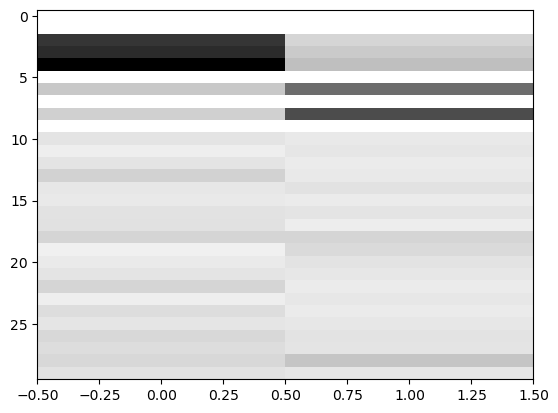

PyObject <matplotlib.image.AxesImage object at 0x2171d43d0>

In [43]:
ax = PyPlot.imshow(res[3][6],aspect="auto",cmap="binary")

## Here we infer the labels for the synthetic observations drawn from a VAE based on testdata.

In [44]:
yhat = annotatesamplesbypattern(Transpose(hcat(testdata...)),xsbin[1:500,:],res[2],ccols)

500-element Vector{String}:
 "r"
 "deepskyblue"
 "lime"
 "lime"
 "deepskyblue"
 "r"
 "r"
 "deepskyblue"
 "r"
 "deepskyblue"
 "r"
 "r"
 "r"
 ⋮
 "deepskyblue"
 "lime"
 "deepskyblue"
 "deepskyblue"
 "deepskyblue"
 "lime"
 "r"
 "r"
 "lime"
 "r"
 "lime"
 "r"

## Here we inspect how synthetic observations were labeled

In [45]:
pzs = zs[1:500,:]

500×2 Matrix{Float64}:
  1.83537     0.780035
  0.574237    1.35055
 -0.61911    -0.0478397
 -1.67271    -0.804393
 -1.08576     0.849453
 -0.236582    1.63015
 -0.78424     1.32964
  2.0496     -1.26169
 -0.903198    0.782839
  1.43365    -0.667955
 -0.87223     1.54306
 -0.895174    0.58959
 -0.533811    1.18865
  ⋮          
  0.571737    0.35067
 -0.847953   -0.476983
  1.5283     -0.123624
 -0.253548   -0.573773
  1.62638     0.0423028
 -0.19164    -2.17828
 -0.0341529   2.07734
 -1.43512     1.0267
  0.0542392   0.807524
 -0.672457    0.466524
 -0.813512   -1.24878
 -0.191802   -1.7923

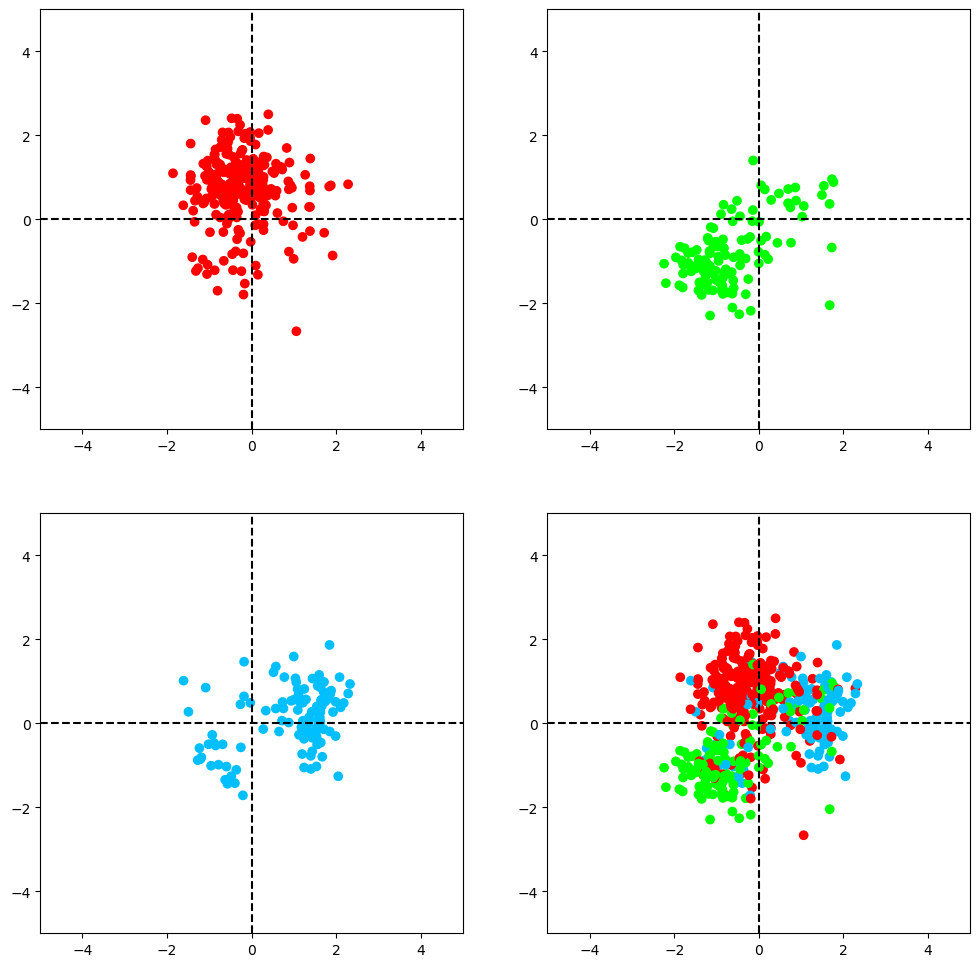

PyObject <matplotlib.lines.Line2D object at 0x21730bf40>

In [46]:
fig, ax = PyPlot.subplots(nrows=2, ncols=2, figsize=(12, 12))
scalepar = 5
ax[1].scatter(pzs[yhat.=="r",1],pzs[yhat.=="r",2],c=yhat[yhat.=="r"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pzs[yhat.=="deepskyblue",1],pzs[yhat.=="deepskyblue",2],c=yhat[yhat.=="deepskyblue"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pzs[yhat.=="lime",1],pzs[yhat.=="lime",2],c=yhat[yhat.=="lime"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pzs[:,1],pzs[:,2],c=yhat)
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

## Now with Tasic et al. data

In [47]:
x = readdlm("data/single_cell_mat.txt",'\t')'

1525×180 adjoint(::Matrix{Float64}) with eltype Float64:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                       

In [48]:
x01 = dichotomize(x)

1525×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.

In [49]:
n,p = size(x01)
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

In [50]:
Random.seed!(1234)
Dh = 30
Dh2 = 10
Dz = 2
epochs = 500
learningrate = 0.004
batchsize=10
Beta =1

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh),Flux.Dense(Dh,Dh2,tanh)),
    Flux.Dense(Dh2,Dz),
    Flux.Dense(Dh2,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end




In [51]:
vaesamples = priorsample.(vcat([testdata for i = 1:5]...))

2805-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([1.3596261370724443, 1.2490688929677063], [0.9363829402396368, 0.01927776119286933, 0.28061093957349886, 0.21794461703544316, 0.05119531287077134, 0.608407003875518, 0.004982730938668921, 0.2795827123329808, 0.49469583576732623, 0.0071638378175214075  …  0.0005087997634012747, 0.019898356280452147, 0.008385421523283065, 0.0886285222984372, 0.10195114850732397, 0.0075300462171203515, 0.06324027937005952, 0.00042831452512481695, 0.000425409651706142, 0.00669864379621794])
 ([1.0606884911744159, 1.1929644078558859], [0.9207991350116029, 0.03341003878990266, 0.2818686381178798, 0.2560765116895359, 0.04811568972314398, 0.6504779059220156, 0.00923049163080936, 0.3153648526781733, 0.5097112454384743, 0.010514842987478843  …  0.0008883424327430064, 0.01949901332208292, 0.012668257967184801, 0.10083806369278053, 0.14437889444484409, 0.010109594196584977, 0.07038301934353187, 0.0009325926531174861, 0.0009947227000593377, 0.009977229

In [52]:
length(vaesamples)

2805

In [53]:
zs = Transpose(cat(dims=2,map(x-> x[1],vaesamples)...))
xs = Transpose(cat(dims=2,map(x-> x[2],vaesamples)...))

2805×180 transpose(::Matrix{Float64}) with eltype Float64:
 0.936383     0.0192778  0.280611  0.217945    …  0.00042541   0.00669864
 0.920799     0.03341    0.281869  0.256077       0.000994723  0.00997723
 0.68081      0.607163   0.301223  0.258983       0.0868848    0.0753408
 0.456773     0.364483   0.515798  0.106896       0.0147745    0.0449409
 0.00028609   0.3951     0.984868  0.0033015      8.6473e-5    0.00321057
 0.730734     0.498556   0.260482  0.274083    …  0.0459981    0.0337928
 0.717889     0.420002   0.357928  0.245024       0.0457933    0.0779666
 0.769447     0.250094   0.389248  0.131857       0.00904104   0.0459999
 0.000305935  0.443044   0.975218  0.00586235     0.000221306  0.00388545
 0.254373     0.282434   0.67023   0.0389449      0.0023408    0.023803
 0.799076     0.286864   0.315384  0.315041    …  0.0255482    0.0515037
 0.204113     0.245688   0.722639  0.0247891      0.000981183  0.0179593
 0.92561      0.0381083  0.243107  0.370179       0.00147716  

In [54]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

2805×180 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.

In [55]:
nvars = 8

8

In [56]:
y = readdlm("data/celltype.txt")[:,1]

1525-element Vector{Any}:
 "Vip"
 "Vip"
 "L4"
 "Vip"
 "Vip"
 "L2/3"
 "L2"
 "L2/3"
 "L4"
 "L2"
 "Pvalb"
 "L2/3"
 "Vip"
 ⋮
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"

## Select variables

In [57]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([989.3942009587754, 671.7826763069547, 443.02598187943374, 326.59163225790627, 298.8640818905589, 220.2317522161224, 205.24480182438288, 192.77411273925526], [150, 1, 155, 84, 37, 88, 27, 71], Any[[195.13648331026354 564.6522701291126; 352.2979314379788 5.5146939843502025; … ; 52.88374120329541 25.77486723743475; 12.21736010736889 7.966667574049151], [121.02438885570677 671.7826763069547; 112.16933179753849 76.91958338923304; … ; 20.124117413459594 19.045940009386232; 2.762259374497405 8.010959697558517], [0.0 0.0; 92.53416328961616 35.1339511002971; … ; 24.002697402211684 25.352967782914387; 5.304264144042568 8.478703296167563], [0.0 0.0; 97.43795213048836 45.27411688536644; … ; 30.15095018843738 24.32097662749095; 10.472784893866914 11.098203038942772], [0.0 0.0; 74.38720722240154 48.13005254657941; … ; 23.577350886893562 29.503678340351254; 11.33008501946715 21.580123298387484], [0.0 0.0; 86.49131252301557 57.46530896699206; … ; 29.752113951514772 27.03102099197809; 24.865717826079

## Annotate synthetic observations

In [58]:
yhat = annotatesamplesbypattern(x01,xsbin[1:1000,:],res[2],y)

1000-element Vector{String}:
 "Sst"
 "L6a"
 "L6a"
 "Pvalb"
 "Vip"
 "Pvalb"
 "L5a"
 "L6a"
 "Vip"
 "Vip"
 "L5b"
 "Vip"
 "L2"
 ⋮
 "L6a"
 "Sst"
 "L6a"
 "Pvalb"
 "L6a"
 "L6a"
 "Sst"
 "Vip"
 "Pvalb"
 "L5a"
 "L6a"
 "Pvalb"

## Compute principal components of synthetic data for plotting

In [59]:
pcs = prcomps(xsbin[1:1000,:])[:,1:2]

1000×2 Matrix{Float64}:
 -3.60474    0.769283
 -3.50351    0.469584
 -1.94803   -1.30422
  0.694116   1.87377
  3.35716    2.70503
 -0.447035  -2.80334
 -4.04565   -0.336949
 -2.1724     0.301394
  4.60085    1.7998
  2.26487    2.06627
 -2.40964    0.420734
  2.09403    2.97918
 -2.37223   -0.157272
  ⋮         
 -4.12056    0.126528
  4.50796    3.23309
 -1.81566    3.32193
 -0.231934  -4.78918
 -0.86264    1.36703
 -0.880161   3.15432
  0.606527   1.15161
  3.78189   -1.12224
  3.28103    0.228567
 -3.88256   -2.56323
 -2.44487   -0.00134725
  0.312218  -2.44707

In [60]:
md = Dict(
    "L4"    => "turquoise",
  "Vip"   => "darkviolet",
  "Sst"   => "gold",
  "L5a"   => "forestgreen",
  "Pvalb" => "orangered",
  "L2"    => "green",
  "L5b"   => "lightgrey",
  "Smad3" => "lightgrey",
  "Igtp"  => "lightgrey",
  "L6b"   => "lightgrey",
  "L2/3"  => "lightgrey",
  "L6a"   => "lightgrey",
  "Sncg"  => "lightgrey",
  "Ndnf"  => "lightgrey",
  "L5"    => "lightgrey"
)

Dict{String, String} with 15 entries:
  "L4"    => "turquoise"
  "Vip"   => "darkviolet"
  "Sst"   => "gold"
  "L2/3"  => "lightgrey"
  "L5a"   => "forestgreen"
  "Pvalb" => "orangered"
  "L2"    => "green"
  "L5b"   => "lightgrey"
  "L6a"   => "lightgrey"
  "Smad3" => "lightgrey"
  "Sncg"  => "lightgrey"
  "Igtp"  => "lightgrey"
  "Ndnf"  => "lightgrey"
  "L6b"   => "lightgrey"
  "L5"    => "lightgrey"

In [61]:
cols = [md[i] for i = y]

1525-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "turquoise"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "green"
 "lightgrey"
 "turquoise"
 "green"
 "orangered"
 "lightgrey"
 "darkviolet"
 ⋮
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"

In [62]:
hatcols = [md[i] for i = yhat]

1000-element Vector{String}:
 "gold"
 "lightgrey"
 "lightgrey"
 "orangered"
 "darkviolet"
 "orangered"
 "forestgreen"
 "lightgrey"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "darkviolet"
 "green"
 ⋮
 "lightgrey"
 "gold"
 "lightgrey"
 "orangered"
 "lightgrey"
 "lightgrey"
 "gold"
 "darkviolet"
 "orangered"
 "forestgreen"
 "lightgrey"
 "orangered"

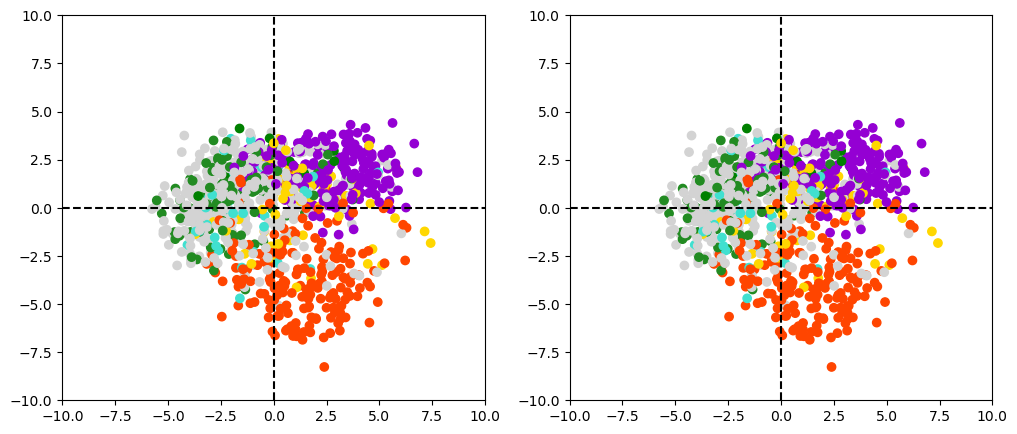

PyObject <matplotlib.lines.Line2D object at 0x218c00a30>

In [63]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

## Plotting separately for individual cell types

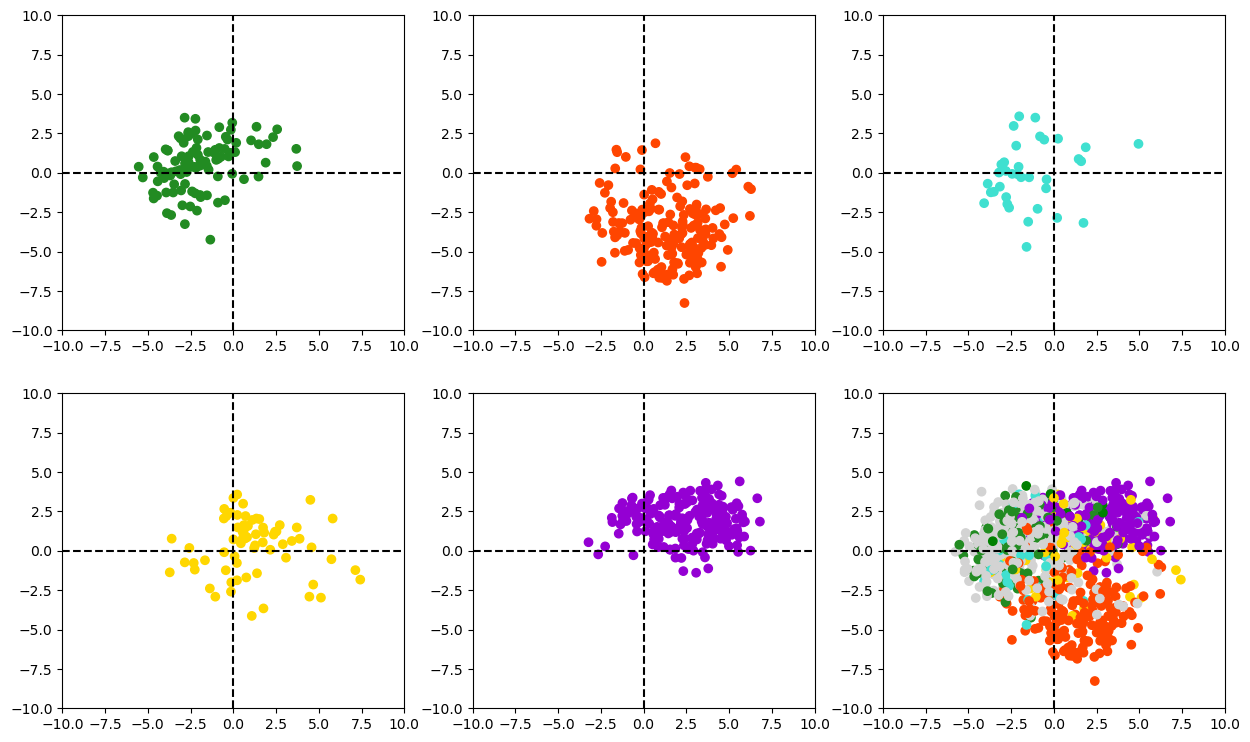

PyObject <matplotlib.lines.Line2D object at 0x218e108e0>

In [64]:
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(15, 9))
scalepar = 10
ax[1].scatter(pcs[hatcols.=="forestgreen",1],pcs[hatcols.=="forestgreen",2],c=hatcols[hatcols.=="forestgreen"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pcs[hatcols.=="gold",1],pcs[hatcols.=="gold",2],c=hatcols[hatcols.=="gold"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pcs[hatcols.=="orangered",1],pcs[hatcols.=="orangered",2],c=hatcols[hatcols.=="orangered"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pcs[hatcols.=="darkviolet",1],pcs[hatcols.=="darkviolet",2],c=hatcols[hatcols.=="darkviolet"])
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

ax[5].scatter(pcs[hatcols.=="turquoise",1],pcs[hatcols.=="turquoise",2],c=hatcols[hatcols.=="turquoise"])
ax[5].set_xlim(-scalepar,scalepar)
ax[5].set_ylim(-scalepar,scalepar)
ax[5].axhline(y = 0.0,c="black",linestyle="--")
ax[5].axvline(x = 0.0,c="black",linestyle="--")

ax[6].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[6].set_xlim(-scalepar,scalepar)
ax[6].set_ylim(-scalepar,scalepar)
ax[6].axhline(y = 0.0,c="black",linestyle="--")
ax[6].axvline(x = 0.0,c="black",linestyle="--")